# Import Libraries

In [12]:
import pandas as pd
import numpy as np

#Use Keras Neural Network Components. This will be used to construct the LSTM
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import LayerNormalization
from keras.layers import MultiHeadAttention
from keras.regularizers import L1L2
from keras.layers import Layer
from keras import Model

#Import Tensorflow 
import tensorflow as tf

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Reproducability of Results

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

# Fetch and Set Up Data

In [14]:
#Numerically Encode the Activities
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [15]:
DATDIR = "data/UCI HAR Dataset"
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]

In [16]:
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_raw_signal_data(train_test, signal):
    file_path = DATDIR + f"/{'train' if train_test == 0 else 'test'}/Inertial Signals/{signal}_{'train' if train_test == 0 else 'test'}.txt"
    return pd.read_csv(file_path, delim_whitespace = True, header = None)

#Same purpose as previous function but, in this case, we are fetching ALL the raw signal data!
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_all_raw_signals(train_test):
    data_raw_signals = []
    for signal in SIGNALS:
        raw_signal_data = fetch_raw_signal_data(train_test, signal).to_numpy()
        data_raw_signals.append(raw_signal_data)
    
    data_raw_signals = np.array(data_raw_signals)
    return np.transpose(data_raw_signals, axes = (1, 2, 0))

#Fetch Labels
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_labels(train_test):
    file_path = DATDIR + f"/{'train' if train_test == 0 else 'test'}/y_{'train' if train_test == 0 else 'test'}.txt"
    return pd.get_dummies(pd.read_csv(file_path, delim_whitespace=True, header = None)[0]).to_numpy()

In [17]:
X_train, X_test, Y_train, Y_test = fetch_all_raw_signals(0), fetch_all_raw_signals(1), fetch_labels(0), fetch_labels(1)

N = X_train.shape[0]
T = X_train.shape[1]
D = X_train.shape[2]

print(N, T, D)

n_classes = Y_train.shape[1]
print(n_classes)
print(X_train.shape, Y_train.shape)

7352 128 9
6
(7352, 128, 9) (7352, 6)


# Define LSTM Architecture

## Architecture 1: 2 LSTM Layers With Attention Layer

In [18]:
##Hyperparameters
epochs = 30
batch_size = 16

n_hidden_1 = 64
n_hidden_2 = 32
n_hidden_3 = 16
n_hidden_4 = 8

dropout_p = 0.5
num_heads = 6

In [19]:
class AttentionBlock(Layer):
    def __init__(self, num_heads, key_dim, fc_dim):
        super().__init__()
        self.dropout = Dropout(0.1)
        self.attention = MultiHeadAttention(num_heads = num_heads, key_dim = key_dim, value_dim = key_dim)
        self.fc = Sequential([Dense(fc_dim, activation="relu")])
        
    def call(self, inputs, training):
        attention_output = self.attention(inputs, inputs)
        attention_output = self.dropout(attention_output, training = training)        
        fc_output = self.fc(attention_output)
        fc_output = self.dropout(fc_output, training = training)
        return fc_output


In [20]:
model = Sequential() #Initializing our Model Architecture

model.add(LSTM(n_hidden_1, input_shape = (T, D), return_sequences=True)) # Add an LSTM Layer
model.add(AttentionBlock(num_heads = num_heads, key_dim = n_hidden_1, fc_dim = n_hidden_2)) #Add a Multihead Attention Layer
model.add(BatchNormalization()) #Add Batch Normalization Layer

model.add(LSTM(n_hidden_3)) #Add another LSTM to come after the AttentionBlock
model.add(BatchNormalization()) #Add Batch Normalization Layer

model.add(Dense(n_hidden_4, activation = "relu")) #Add another Dense Layer
model.add(Dropout(dropout_p)) # Adding a dropout layer
model.add(Dense(n_classes, activation = 'softmax')) #Adding a Dense Layer with the Softmax Activation Function

model.summary() #Display a Summary of our model architecture

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128, 64)           18944     
                                                                 
 attention_block_1 (Attenti  (None, 128, 32)           101600    
 onBlock)                                                        
                                                                 
 batch_normalization_2 (Bat  (None, 128, 32)           128       
 chNormalization)                                                
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 batch_normalization_3 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                      

In [21]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [22]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 72s 145ms/step - loss: 1.2141 - accuracy: 0.5011 - val_loss: 1.1345 - val_accuracy: 0.5908
Epoch 2/30
460/460 [==============================] - 65s 141ms/step - loss: 0.8912 - accuracy: 0.6243 - val_loss: 0.4671 - val_accuracy: 0.8612
Epoch 3/30
460/460 [==============================] - 65s 141ms/step - loss: 0.7518 - accuracy: 0.6842 - val_loss: 0.3572 - val_accuracy: 0.8575
Epoch 4/30
460/460 [==============================] - 66s 144ms/step - loss: 0.7006 - accuracy: 0.7087 - val_loss: 0.3062 - val_accuracy: 0.8914
Epoch 5/30
460/460 [==============================] - 61s 133ms/step - loss: 0.7194 - accuracy: 0.6990 - val_loss: 0.3160 - val_accuracy: 0.9002
Epoch 6/30
460/460 [==============================] - 56s 122ms/step - loss: 0.6775 - accuracy: 0.7122 - val_loss: 0.3031 - val_accuracy: 0.9094
Epoch 7/30
460/460 [==============================] - 61s 133ms/step - loss: 0.6818 - accuracy: 0.7126 - val_loss: 0.3725 - val_ac

In [23]:
def generate_confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [24]:
#Generate Confusion Matrix
confusion_matrix = generate_confusion_matrix(Y_test, model.predict(X_test))

93/93 [==============================] - 7s 70ms/step


/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_47549/548805115.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


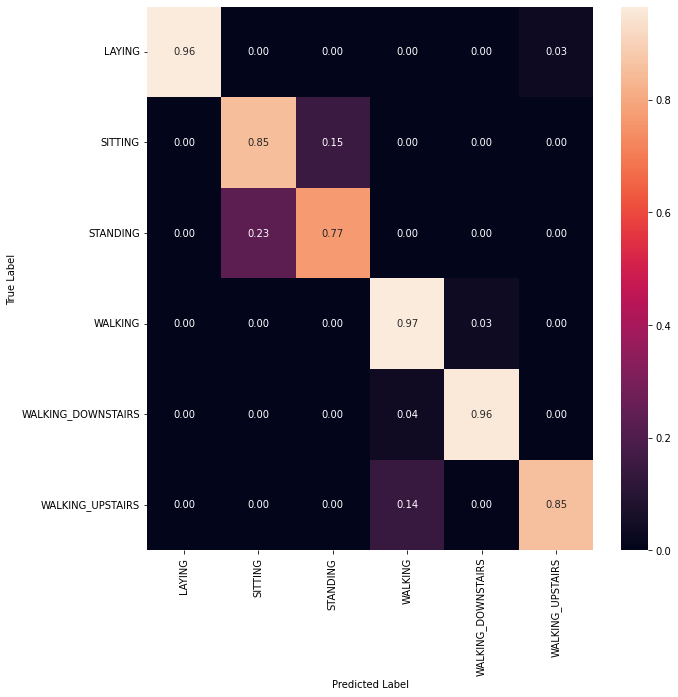

In [25]:
#Plot Normalized Confusion Matrix

# Calculate normalized confusion matrix
normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

#List out target names
target_names = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [26]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 6s 69ms/step - loss: 0.4173 - accuracy: 0.8911

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.4173092842102051, 0.8910756707191467]


## Architecture 2: Use 2 LSTM Layers

In [27]:
##Hyperparameters
epochs = 30
batch_size = 16
n_hidden_1 = 64
dropout_p = 0.5
n_hidden_2 = 32
n_hidden_3 = 16

In [28]:
model = Sequential() #Initializing our Model Architecture

#Define LSTM Layer with Batch Normalization
model.add(LSTM(n_hidden_1, input_shape=(T, D), return_sequences=True))
model.add(BatchNormalization())

#Define Dropout Layer
model.add(Dropout(dropout_p))

#Define the second LSTM Layer with Batch Normalization
model.add(LSTM(n_hidden_2))
model.add(BatchNormalization())

#Define Dropout Layer
model.add(Dropout(dropout_p))

#Define Dense Layer
model.add(Dense(n_hidden_3, activation = 'relu'))

#Define Dense Layer
model.add(Dense(n_classes, activation = 'softmax'))

#Print Model Summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128, 64)           18944     
                                                                 
 batch_normalization_4 (Bat  (None, 128, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_5 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [29]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [30]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 28s 54ms/step - loss: 0.9977 - accuracy: 0.6030 - val_loss: 0.8470 - val_accuracy: 0.6454
Epoch 2/30
460/460 [==============================] - 24s 52ms/step - loss: 0.5392 - accuracy: 0.7980 - val_loss: 0.9243 - val_accuracy: 0.6328
Epoch 3/30
460/460 [==============================] - 24s 53ms/step - loss: 0.3291 - accuracy: 0.8872 - val_loss: 0.3698 - val_accuracy: 0.8629
Epoch 4/30
460/460 [==============================] - 24s 52ms/step - loss: 0.2435 - accuracy: 0.9120 - val_loss: 0.7096 - val_accuracy: 0.8056
Epoch 5/30
460/460 [==============================] - 24s 53ms/step - loss: 0.2428 - accuracy: 0.9217 - val_loss: 0.3579 - val_accuracy: 0.8968
Epoch 6/30
460/460 [==============================] - 24s 51ms/step - loss: 0.2265 - accuracy: 0.9195 - val_loss: 0.3859 - val_accuracy: 0.9087
Epoch 7/30
460/460 [==============================] - 24s 53ms/step - loss: 0.2097 - accuracy: 0.9289 - val_loss: 8.0519 - val_accuracy:

In [31]:
#Generate Confusion Matrix
confusion_matrix = generate_confusion_matrix(Y_test, model.predict(X_test))

93/93 [==============================] - 3s 20ms/step


/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_47549/548805115.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


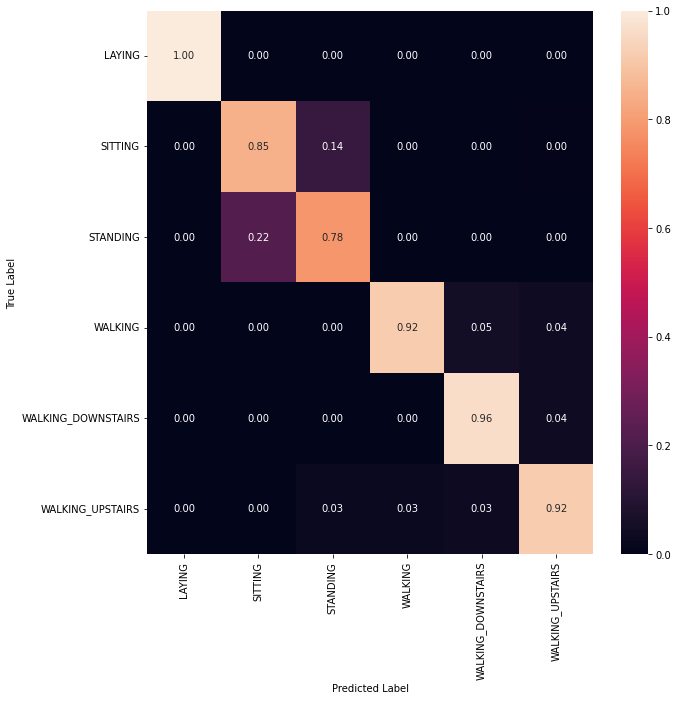

In [32]:
#Plot Normalized Confusion Matrix

# Calculate normalized confusion matrix
normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

#List out target names
target_names = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [33]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 2s 25ms/step - loss: 0.7113 - accuracy: 0.9033

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.7113261818885803, 0.9032914638519287]


## Architecture 3: Use 1 LSTM Layer

In [34]:
##Hyperparameters
epochs = 30
batch_size = 16
n_hidden_1 = 32
n_hidden_2 = 16
dropout_p = 0.5

In [35]:
model = Sequential() #Initializing our Model Architecture

# Add an LSTM Layer
model.add(LSTM(n_hidden_1, input_shape = (T, D)))

# Adding a dropout layer
model.add(Dropout(dropout_p))

#Add another Dense Layer
model.add(Dense(n_hidden_2, activation = "relu"))

# Adding a Dense Layer with the Softmax Activation Function
model.add(Dense(n_classes, activation = 'softmax'))

model.summary() #Display a Summary of our model architecture

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                5376      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 6)                 102       
                                                                 
Total params: 6006 (23.46 KB)
Trainable params: 6006 (23.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [37]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 16s 30ms/step - loss: 1.1480 - accuracy: 0.5246 - val_loss: 0.9187 - val_accuracy: 0.6305
Epoch 2/30
460/460 [==============================] - 318s 692ms/step - loss: 0.7021 - accuracy: 0.7002 - val_loss: 0.6967 - val_accuracy: 0.7133
Epoch 3/30
460/460 [==============================] - 16s 35ms/step - loss: 0.5649 - accuracy: 0.7626 - val_loss: 0.6714 - val_accuracy: 0.7380
Epoch 4/30
460/460 [==============================] - 13s 29ms/step - loss: 0.4804 - accuracy: 0.8006 - val_loss: 0.6290 - val_accuracy: 0.7910
Epoch 5/30
460/460 [==============================] - 65s 142ms/step - loss: 0.3895 - accuracy: 0.8566 - val_loss: 0.5227 - val_accuracy: 0.8405
Epoch 6/30
460/460 [==============================] - 122s 265ms/step - loss: 0.3004 - accuracy: 0.9027 - val_loss: 0.5562 - val_accuracy: 0.8585
Epoch 7/30
460/460 [==============================] - 155s 338ms/step - loss: 0.2560 - accuracy: 0.9189 - val_loss: 0.6253 - val_ac

In [38]:
def generate_confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [39]:
#Generate Confusion Matrix
confusion_matrix = generate_confusion_matrix(Y_test, model.predict(X_test))

93/93 [==============================] - 1s 9ms/step


/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_47549/548805115.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


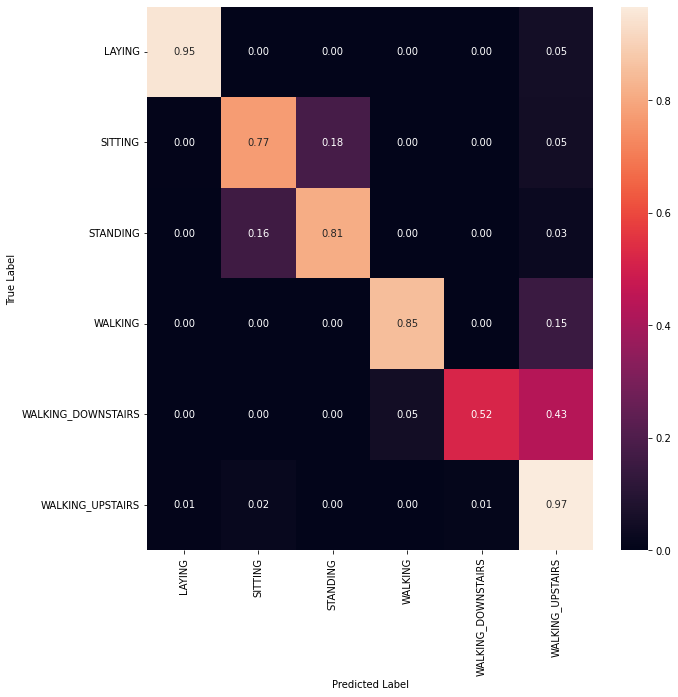

In [40]:
#Plot Normalized Confusion Matrix

# Calculate normalized confusion matrix
normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

#List out target names
target_names = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [41]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 1s 9ms/step - loss: 1.4618 - accuracy: 0.8188

   cat_crossentropy  ||   accuracy 
  ____________________________________
[1.4617618322372437, 0.8187987804412842]
